In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix,f1_score,roc_curve,auc,roc_auc_score
from sklearn import metrics
from sklearn.neural_network import MLPClassifier

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
import optuna as op
from sklearn.preprocessing import StandardScaler
import tensorflow_addons as tfa
from keras import backend as K
import tensorflow as tf 

In [20]:
import dill
dill.dump_session('env.db')
#dill.load_session('env.db')

In [3]:
df = pd.read_csv("bank_seasons.csv")
df['y'].value_counts()
#imbalanced dataset

#split dataset
x=df.drop('y', axis=1)
y=df['y']
x_train, x_test, y_train, y_test = train_test_split(x,y,random_state=1,train_size=0.7)
print(y_train.value_counts())
print(x_train.shape)
#print(x_test.shape)

#balance dataset (SMOTE)
smote=SMOTE(random_state=1) 
x_train_b, y_train_b = smote.fit_resample(x_train,y_train)
print(y_train_b.value_counts())

ss = StandardScaler()
x_train_b = pd.DataFrame(ss.fit_transform(x_train_b),columns=x_train_b.columns)
x_test_b = pd.DataFrame(ss.transform(x_test),columns=x_test.columns)
print(x_train_b.shape,y_train_b.shape)

ss1 = StandardScaler()
x_train_ub = pd.DataFrame(ss1.fit_transform(x_train),columns=x_train.columns)
x_test_ub = pd.DataFrame(ss1.transform(x_test),columns=x_test.columns)
print(x_train_ub.shape,y_train.shape)

0    27909
1     3738
Name: y, dtype: int64
(31647, 32)
0    27909
1    27909
Name: y, dtype: int64
(55818, 32) (55818,)
(31647, 32) (31647,)


In [430]:
print(y_test.value_counts())

0    12013
1     1551
Name: y, dtype: int64


In [428]:

model_mlp = MLPClassifier(max_iter=900000,alpha = 0.01,hidden_layer_sizes=(128,64,35,16,8),solver='adam',batch_size=64)
model_mlp.fit(x_train_b,y_train_b)
y_pred = model_mlp.predict(x_train_b)

scores = metrics.accuracy_score(y_train_b,y_pred)
print("training acc ",scores)

y_pred1 = model_mlp.predict(x_test_b)
scores1 = metrics.accuracy_score(y_test,y_pred1)
f11 = metrics.f1_score(y_test,y_pred1)
auc1 = metrics.roc_auc_score(y_test,y_pred1)
print("testing acc ",scores1)
print("testing f1 ",f11)
print("testing auc ",auc1)


testing acc  0.8807873783544677
testing f1  0.46791707798617965
testing auc  0.6968669982116408


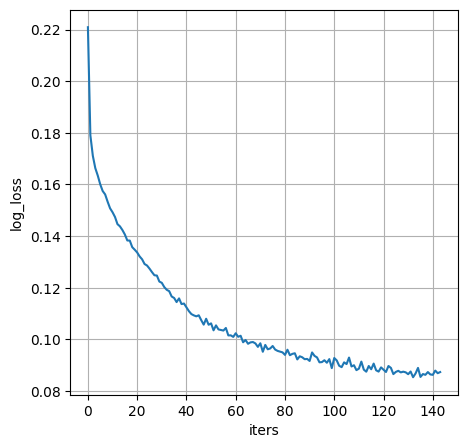

              precision    recall  f1-score   support

           0       0.93      0.94      0.93     12013
           1       0.48      0.46      0.47      1551

    accuracy                           0.88     13564
   macro avg       0.70      0.70      0.70     13564
weighted avg       0.88      0.88      0.88     13564



In [387]:

if model_mlp.solver == 'sgd' or model_mlp.solver=='adam':
    plt.figure(figsize=(5,5))
    plt.plot(model_mlp.loss_curve_)
    plt.xlabel("iters")
    plt.ylabel(model_mlp.loss)
    plt.grid()
    plt.show()
print(classification_report(y_test, y_pred1))

In [4]:
x_val_ub = x_train_ub[:1000]
x_val_b = x_train_b[:1000]
y_val_b = y_train_b[:1000]
y_val_ub = y_train[:1000]

x_train_ub = x_train_ub[1000:]
y_train_ub= y_train[1000:]
print(x_train.shape,y_train.shape)
print(x_train_ub.shape,y_train_ub.shape)

(31647, 32) (31647,)
(30647, 32) (30647,)


In [5]:
def getReport(model,x_test,y_test):
    y_pred = model.predict(x_test)
    y_pred[y_pred>0.5]=1
    y_pred[y_pred<0.5]=0

    model.evaluate(x_test,y_test)
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred, labels=[0,1])
    print("confusion_matrix:\n",cm)


In [6]:
def getROC(model,x_test,y_test):
    y_pred = model.predict(x_test)
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'orange', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'b--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [8]:
def getCurve(history,curve_type):
    loss_values = history.history[curve_type]
    strval = 'val_' + curve_type
    val_loss_values = history.history[strval]
    epochs = range(1, len(loss_values) + 1)

    # val_1 = {"epochs": epochs, "val_loss": val_loss_values}
    # val_pd_1 = pd.DataFrame(val_1)
    # val_pd_1["val_loss"].min() # find the epochs with the minimum validation loss
    # print(val_pd_1[val_pd_1["val_loss"] == val_pd_1["val_loss"].min()]) 

    #Visulization of validation loss
    plt.plot(epochs, loss_values,color = 'lightseagreen', label='Training '+curve_type)
    plt.plot(epochs, val_loss_values,color = 'lightcoral', label='Validation '+curve_type)
    plt.title('Training and validation '+curve_type)
    plt.xlabel('Epochs')
    plt.ylabel(curve_type)
    plt.grid()
    plt.legend()

In [9]:

def focal_loss_custom(alpha, gamma):
   def binary_focal_loss(y_true, y_pred):
      fl = tfa.losses.SigmoidFocalCrossEntropy(alpha=alpha, gamma=gamma)
      y_true_K = K.ones_like(y_true)
      focal_loss = fl(y_true, y_pred)
      return focal_loss
   return binary_focal_loss

In [462]:
model_bce = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(32,)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(8, activation='relu'),
    #tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(4, activation='relu'),
    #tf.keras.layers.Dropout(0.4), 
    tf.keras.layers.Dense(1, activation='sigmoid')
])


def f1(y_true, y_pred):
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    precision = true_positives / (predicted_positives + K.epsilon())
    f1 = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1

#model.compile(loss='binary_crossentropy', optimizer= "rmsprop", metrics=['accuracy'])
model_bce.compile(loss='binary_crossentropy', optimizer= "rmsprop", metrics=[f1,'accuracy','AUC'])
history_bce = model_bce.fit(x_train_b, y_train_b, epochs=35,shuffle=True, validation_data=(x_val_b,y_val_b),batch_size=128)

Epoch 1/35
437/437 [==============================] - 3s 4ms/step - loss: 0.3151 - f1: 0.8729 - accuracy: 0.8753 - auc: 0.9428 - val_loss: 0.2950 - val_f1: 0.4770 - val_accuracy: 0.8820 - val_auc: 0.8730
Epoch 2/35
437/437 [==============================] - 2s 4ms/step - loss: 0.2093 - f1: 0.9170 - accuracy: 0.9196 - auc: 0.9724 - val_loss: 0.2755 - val_f1: 0.5343 - val_accuracy: 0.8940 - val_auc: 0.8815
Epoch 3/35
437/437 [==============================] - 2s 3ms/step - loss: 0.1976 - f1: 0.9222 - accuracy: 0.9244 - auc: 0.9754 - val_loss: 0.2794 - val_f1: 0.5402 - val_accuracy: 0.8850 - val_auc: 0.8884
Epoch 4/35
437/437 [==============================] - 1s 3ms/step - loss: 0.1911 - f1: 0.9229 - accuracy: 0.9250 - auc: 0.9767 - val_loss: 0.2810 - val_f1: 0.5261 - val_accuracy: 0.8860 - val_auc: 0.8915
Epoch 5/35
437/437 [==============================] - 2s 3ms/step - loss: 0.1862 - f1: 0.9249 - accuracy: 0.9268 - auc: 0.9779 - val_loss: 0.2668 - val_f1: 0.5228 - val_accuracy: 0.887

In [20]:

model_FL = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(32,)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(8, activation='relu'),
    #tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(4, activation='relu'),
    #tf.keras.layers.Dropout(0.4), 
    tf.keras.layers.Dense(1, activation='sigmoid')
])


def f1(y_true, y_pred):
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    precision = true_positives / (predicted_positives + K.epsilon())
    f1 = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1

#model.compile(loss='binary_crossentropy', optimizer= "rmsprop", metrics=['accuracy'])
model_FL.compile(loss=focal_loss_custom(alpha=0.75, gamma=1.5), optimizer= 'rmsprop', metrics=[f1,'accuracy','AUC'])
history_FL = model_FL.fit(x_train_ub, y_train_ub, epochs=250,shuffle=True, validation_data=(x_val_ub,y_val_ub),batch_size=128)

Epoch 1/150
240/240 [==============================] - 2s 4ms/step - loss: 0.0611 - f1: 0.1561 - accuracy: 0.8432 - auc: 0.6860 - val_loss: 0.0456 - val_f1: 0.5486 - val_accuracy: 0.8770 - val_auc: 0.8771
Epoch 2/150
240/240 [==============================] - 1s 3ms/step - loss: 0.0464 - f1: 0.4938 - accuracy: 0.8710 - auc: 0.8659 - val_loss: 0.0436 - val_f1: 0.5503 - val_accuracy: 0.8680 - val_auc: 0.8863
Epoch 3/150
240/240 [==============================] - 1s 3ms/step - loss: 0.0440 - f1: 0.5267 - accuracy: 0.8691 - auc: 0.8809 - val_loss: 0.0451 - val_f1: 0.5423 - val_accuracy: 0.8590 - val_auc: 0.8915
Epoch 4/150
240/240 [==============================] - 1s 3ms/step - loss: 0.0429 - f1: 0.5421 - accuracy: 0.8748 - auc: 0.8872 - val_loss: 0.0427 - val_f1: 0.5662 - val_accuracy: 0.8750 - val_auc: 0.8944
Epoch 5/150
240/240 [==============================] - 1s 3ms/step - loss: 0.0418 - f1: 0.5493 - accuracy: 0.8767 - auc: 0.8925 - val_loss: 0.0432 - val_f1: 0.5722 - val_accuracy: 

In [23]:
getReport(model_FL,x_test_ub,y_test)
#getReport(model_bce,x_test_b,y_test)

424/424 [==============================] - 1s 1ms/step - loss: 0.0391 - f1: 0.5537 - accuracy: 0.8790 - auc: 0.9069
              precision    recall  f1-score   support

           0       0.96      0.90      0.93     12013
           1       0.48      0.73      0.58      1551

    accuracy                           0.88     13564
   macro avg       0.72      0.82      0.76     13564
weighted avg       0.91      0.88      0.89     13564

confusion_matrix:
 [[10786  1227]
 [  414  1137]]


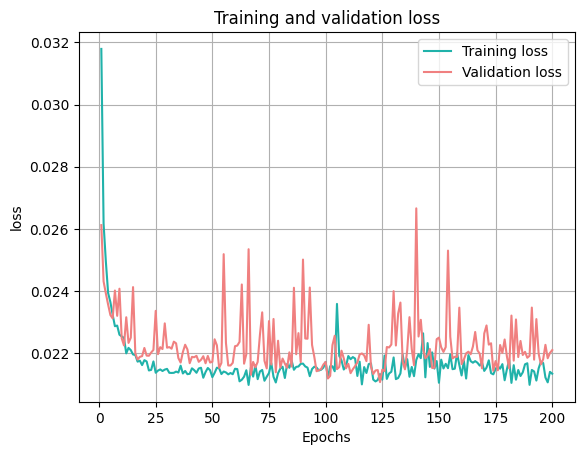

In [478]:
getCurve(history_FL,'loss')


424/424 [==============================] - 0s 984us/step


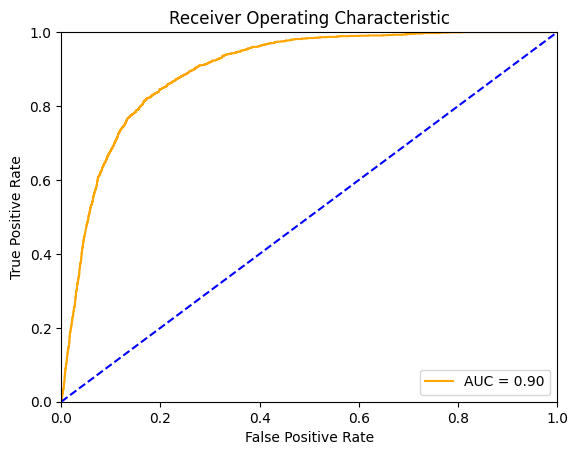

In [466]:
# getROC(model_FL,x_test_ub,y_test)
getROC(model_bce,x_test_b,y_test)